In [5]:
%load_ext autoreload
%autoreload 2
from trainer import LitModel
import torch 
from shared_modules.data_module_all import DataModule
from shared_modules.utils import load_config
from monai.transforms import AsDiscrete
from tqdm import tqdm
from monai.metrics import DiceMetric
from shared_modules.plotting import plot_metrics, plot_confusion, plot_difference
from shared_modules.torch_metrics import PicaiMetric
from shared_modules.post_transforms import get_post_transforms
from monai.data import decollate_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
SAVE_PROB_MAPS = False
SAVE_PREDS = False

config = load_config("config.yaml")
config.data.data_dir = "../../../data/"
config.data.json_list = "../../../json_datalists/picai/all_samples.json"
gpu = 0
config.gpus = [gpu]
config.cache_rate = 1.0
config.transforms.label_keys=["pca", "prostate"]
config.transforms.crop_key = "prostate"
# config.transforms.image_keys = ["t2w", "adc", "hbv"]
config.transforms.image_keys = ["image"]
label_key = config.transforms.label_keys[0]

In [7]:
weights_folder = "../../../gc_algorithms/base_container/models/umamba_mtl/weights/"
models = []

for i in range(5):
    models.append(LitModel.load_from_checkpoint(f"{weights_folder}f{i}.ckpt", config=config, map_location=f"cuda:{gpu}"))
    # disable randomness, dropout, etc...
    models[-1].eval()
    models[-1].to(gpu)

In [8]:

dm = DataModule(
    config=config,
)

dm.setup("test")
dl = dm.test_dataloader()

Loading dataset: 100%|██████████| 1499/1499 [05:27<00:00,  4.57it/s]


In [9]:
prob_map_post_transforms = get_post_transforms(key="prob", 
                    orig_key=label_key,
                    orig_transforms=dm.transforms["test"],
                    out_dir=f"output/prob/",
                    keep_n_largest_components=0,
                    output_postfix="",
                    output_dtype="float32",
                    save_mask=SAVE_PROB_MAPS) # True

pca_post_transforms = get_post_transforms(key="pca", 
                    orig_key=label_key,
                    orig_transforms=dm.transforms["test"],
                    out_dir=f"output/pred/",
                    keep_n_largest_components=0,
                    output_postfix="",
                    output_dtype="float32",
                    save_mask=SAVE_PREDS) # True

In [10]:
dsc_fn = DiceMetric(include_background=False, reduction="mean")
picai_metric_fn = PicaiMetric()

all_probs = []
all_gts = []


for batch in tqdm(dl):
    with torch.no_grad():
        x = batch["image"].to(gpu)

        preds = []
        probs = []
        
        for fold, model in enumerate(models):
            logits = model.inferer(x)
            preds.append(AsDiscrete(argmax=True)(logits[0])[None])
            probs.append(torch.sigmoid(logits[0,1])[None][None])
            
        
    batch["prob"] = torch.mean(torch.stack(probs), dim=0)
    
    # Reverts back to original size
    batch["prob"] = [prob_map_post_transforms(i)["prob"] for i in decollate_batch(batch)][0][None]
    batch["pca"] = [pca_post_transforms(i)["pca"] for i in decollate_batch(batch)][0][None]
    batch["pred"] = (batch["prob"] > 0.5).float()
     
    all_probs.append(batch["prob"][0,0,...].cpu().numpy())
    all_gts.append(batch["pca"][0,0,...].cpu().numpy())
    
    dsc_fn(y_pred=batch["pred"], y=batch["pca"].to(gpu))
        
dsc_metrics = dsc_fn.aggregate("none")

  0%|          | 0/1499 [00:00<?, ?it/s]

100%|██████████| 1499/1499 [10:17<00:00,  2.43it/s]


In [11]:
import picai_eval
from report_guided_annotation import extract_lesion_candidates

metrics = picai_eval.evaluate(
            y_det=all_probs,
            y_true=all_gts,
            y_det_postprocess_func=lambda pred: extract_lesion_candidates(pred, threshold="dynamic")[0],
            y_true_postprocess_func=lambda y: y,
            num_parallel_calls=10
        )

metrics

Metrics(auroc=89.53%, AP=67.05%, 1499 cases, 435 lesions)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


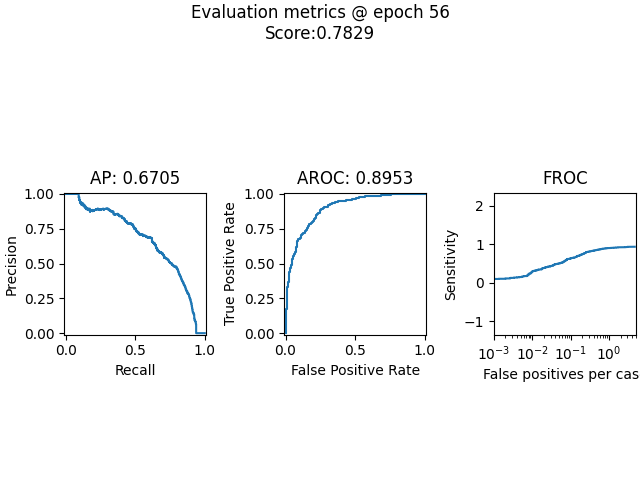

In [12]:
plot_metrics(metrics,56)

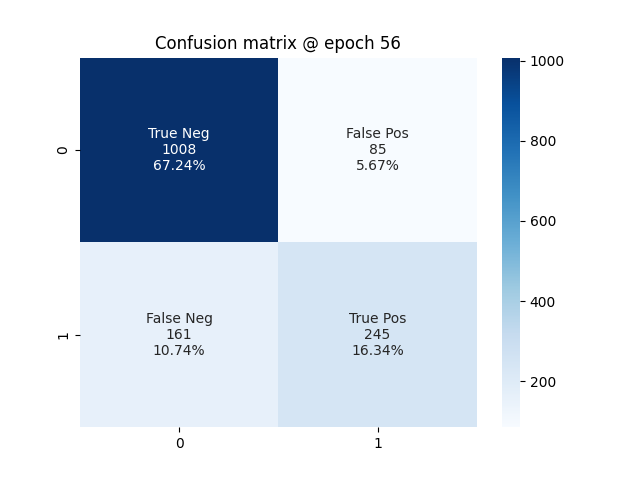

In [13]:
plot_confusion(metrics, 56, threshold=0.5)